In [1]:
from tqdm import tqdm
import itertools
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from matplotlib import gridspec
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import datetime

from scipy.stats import norm, describe
from scipy.optimize import curve_fit

import math
from scipy.special import gamma, jv

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import itertools
marker = itertools.cycle((',', '+', '.', 'o', '*')) 

In [11]:
MSD_trend_df = pd.read_csv("../MSD_trends.csv", index_col = 0) 
MSD_seasonality_df = pd.read_csv("../MSD_seasonality.csv", parse_dates=True, index_col = 0) 

In [12]:
# MSD_trend_df = MSD_trend_df.drop(['NCR'], axis=1)
# MSD_seasonality_df = MSD_seasonality_df.drop(['NCR'], axis=1)

In [13]:
def plot_in_log():
    plt.grid(alpha = 0.5)
    plt.xscale("log")
    plt.yscale("log")
#     plt.legend()
    
def plot_labels():
    plt.xlabel(r"$\tau$")
    plt.ylabel("MSD")
    


Plotting MSD: 15it [00:00, 151.45it/s]


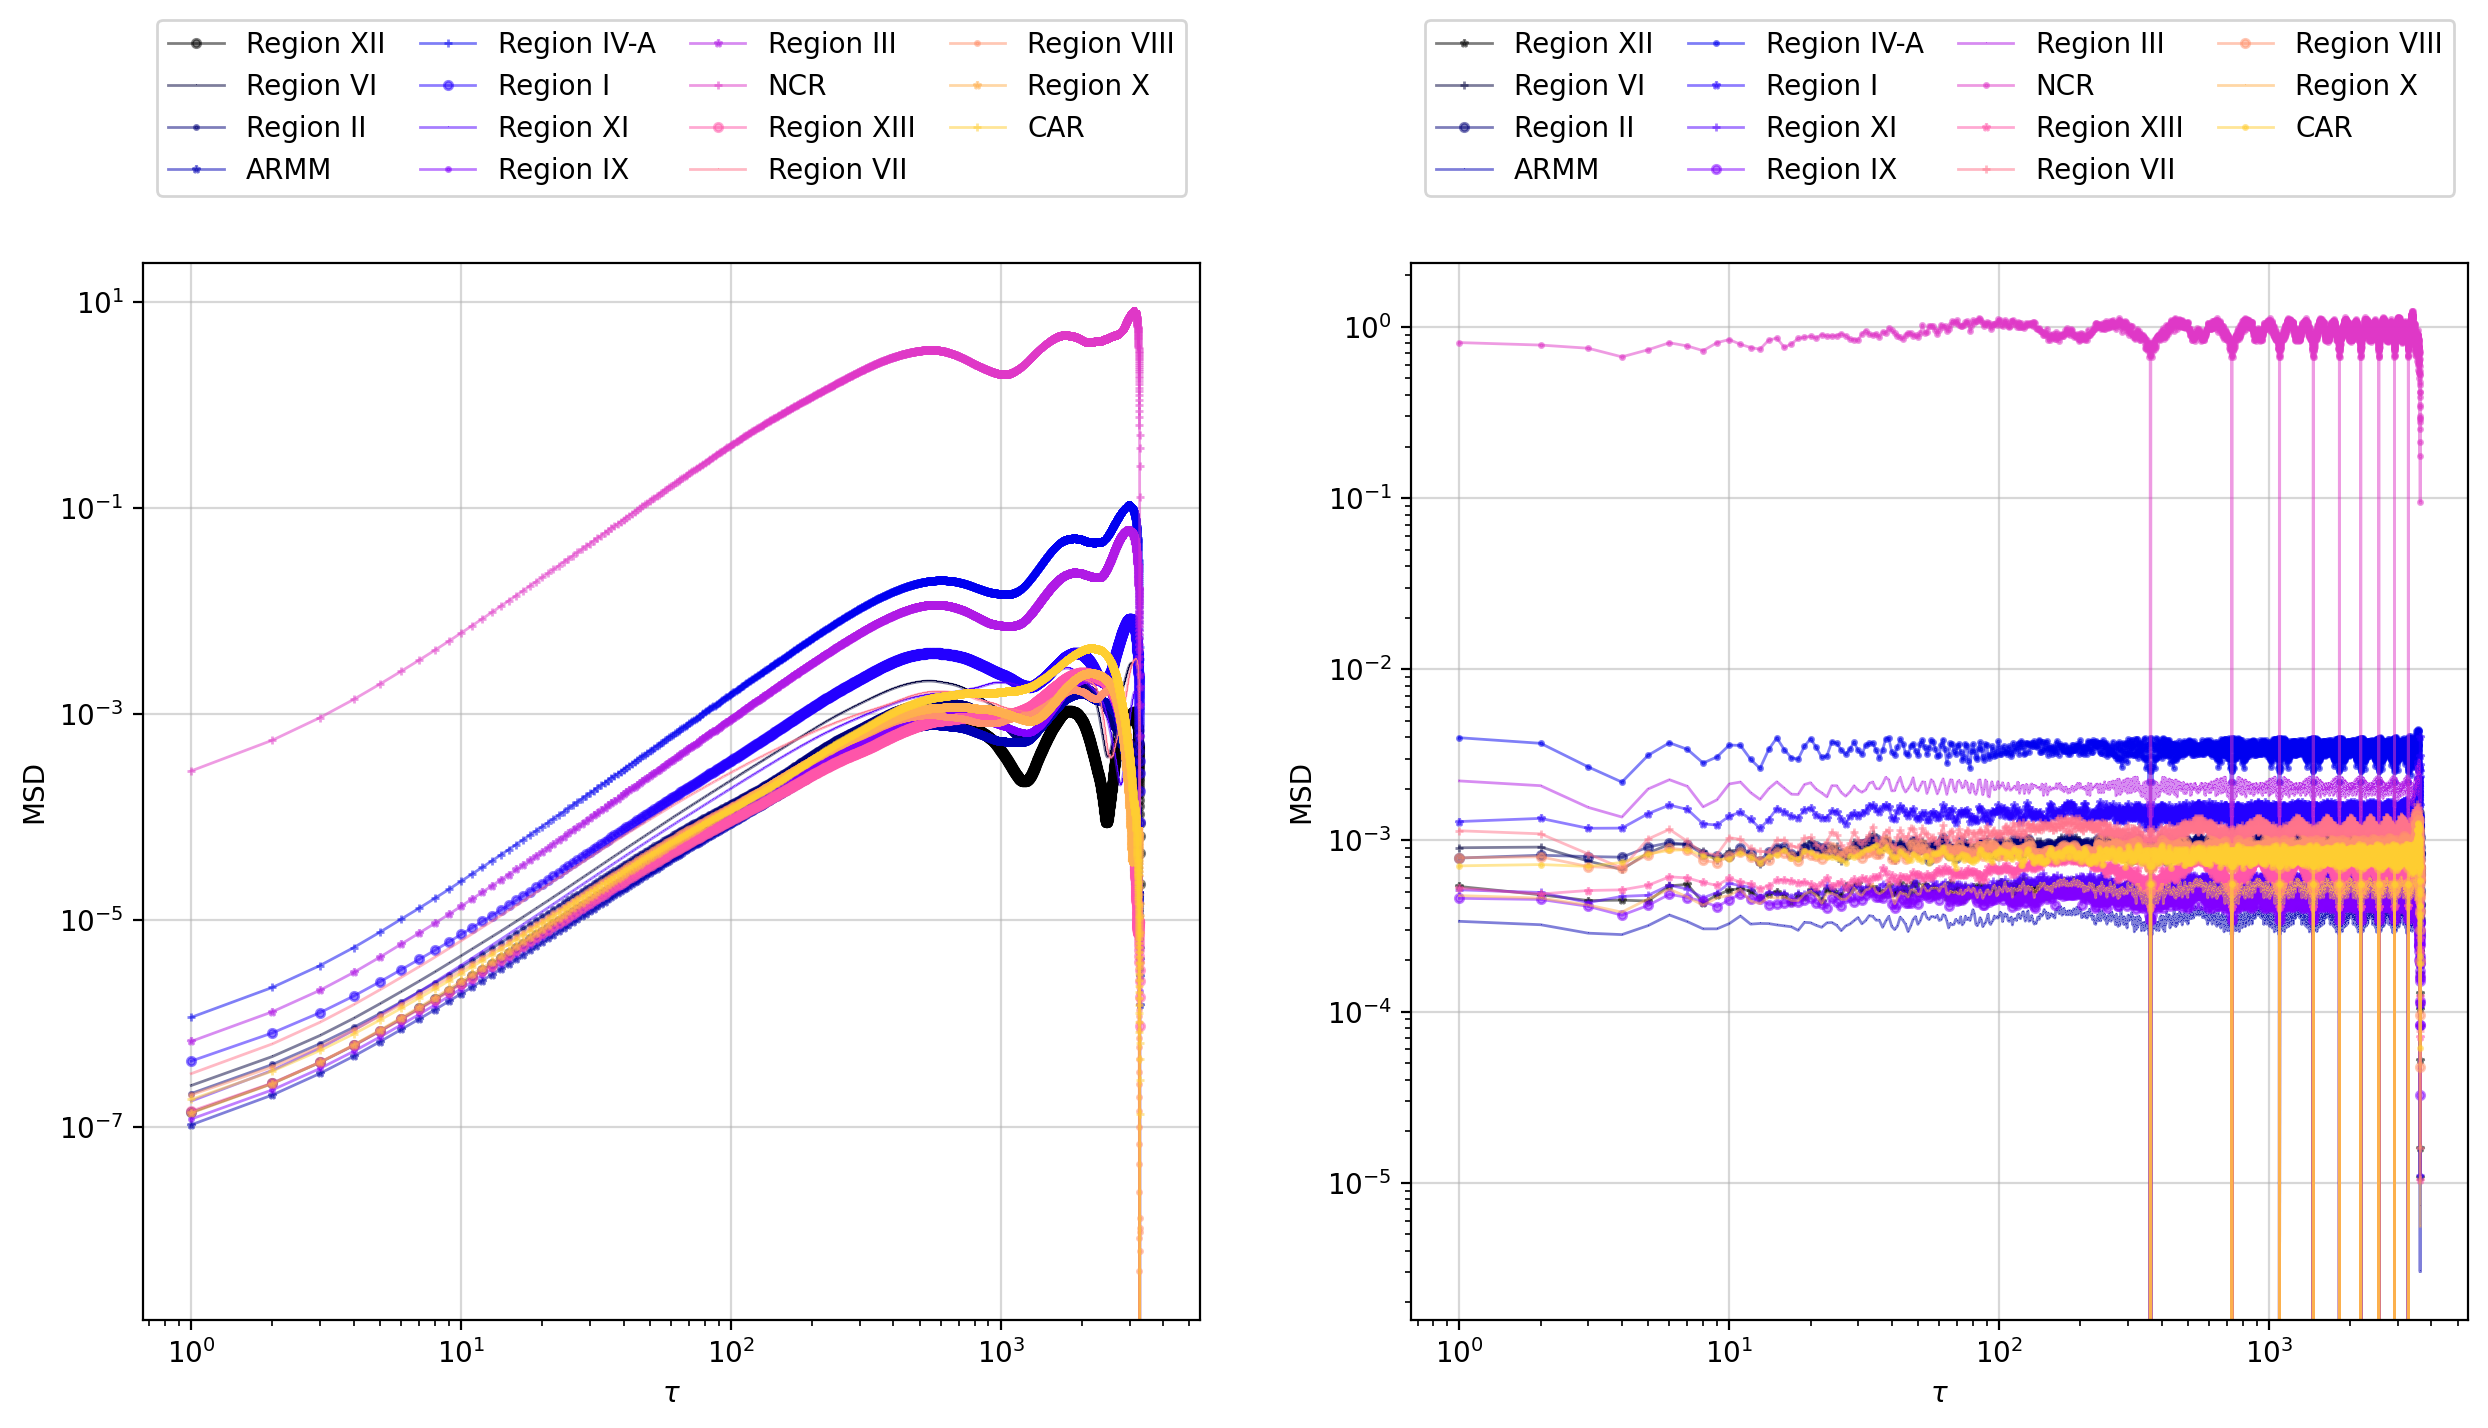

In [14]:
fig = plt.figure(dpi = 200, figsize = (15,7))
fig.patch.set_facecolor('None')

for i, loc in tqdm(enumerate(MSD_trend_df.columns), desc = 'Plotting MSD'):
    plt.subplot(121)
    plt.plot(MSD_trend_df[loc], '-', label = loc, lw = 1,
             color = plt.cm.gnuplot2(i/17), ms = 3, alpha = 0.5, marker = next(marker))
    plt.legend(fontsize=10, ncol = 4, bbox_to_anchor= (0, 1.05, 1, 0.5), loc="lower left",
                bbox_transform=plt.gca().transAxes, fancybox = True, mode='expand')
    plot_in_log()
    plot_labels()
    
    plt.subplot(122)
    plt.plot(MSD_seasonality_df[loc], '-', label = loc, lw = 1,
             color = plt.cm.gnuplot2(i/17), ms = 3, alpha = 0.5, marker = next(marker))
    plt.legend(fontsize=10, ncol = 4, bbox_to_anchor= (0, 1.05, 1, 0.5), loc="lower left",
                bbox_transform=plt.gca().transAxes, fancybox = True, mode='expand')
    
    plot_in_log()
    plot_labels()

In [15]:
def msd_theo_ntl(T,v,mu):
    num = gamma(mu)*np.cos((v*T)/2)*jv(1,(v*T)/2)
    denom = np.pi**(-0.5) * T**(0.5-mu) * v**(mu-0.5)
    return num/denom

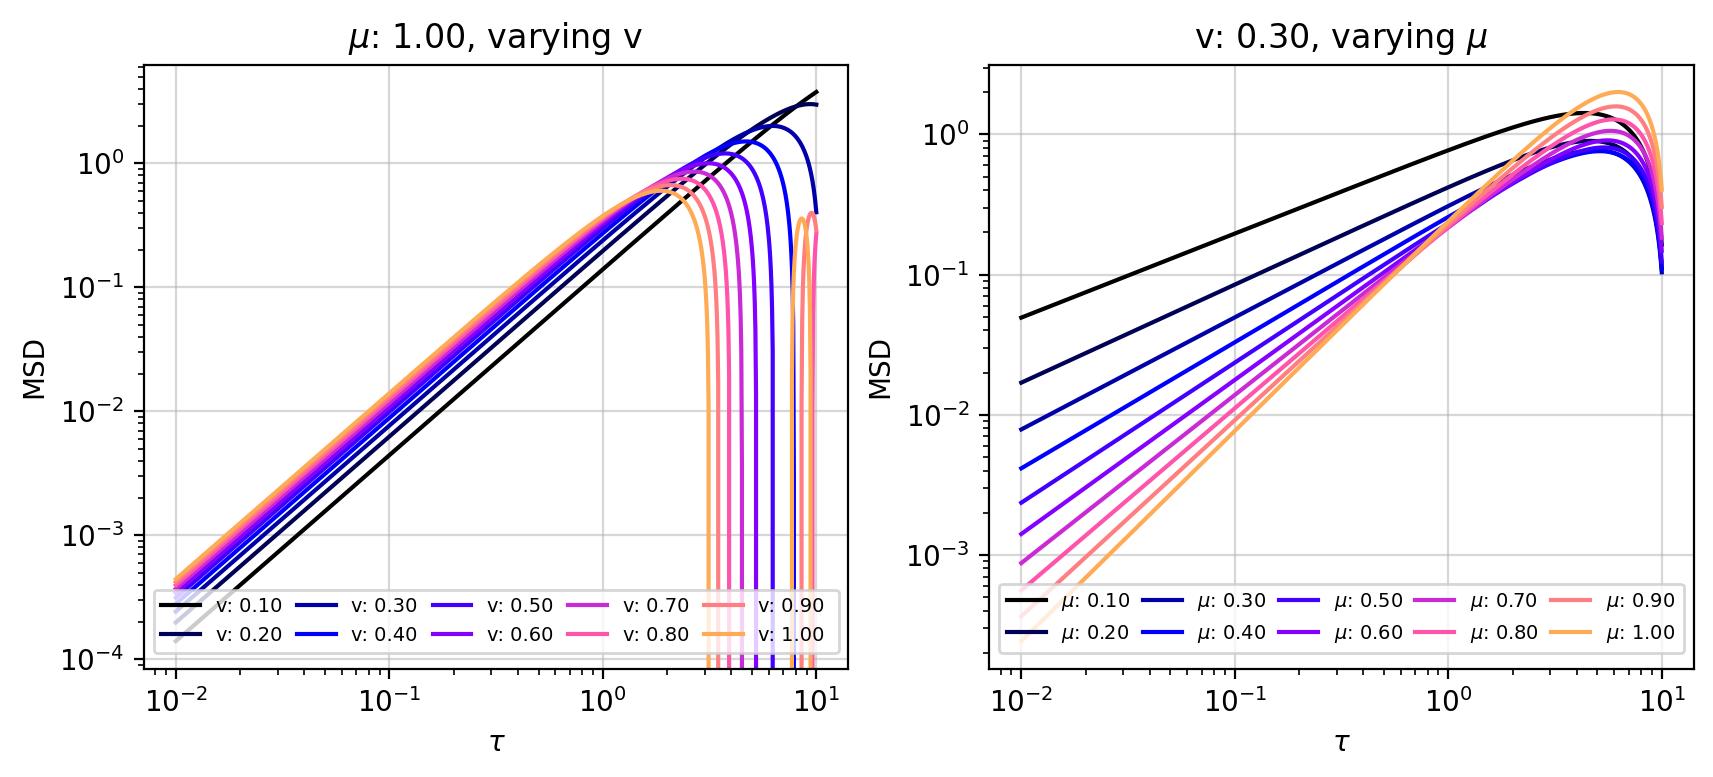

In [28]:
t = np.logspace(-2, 1, 1000)
v_vals = np.linspace(0.1,1,10)
mu_vals = np.linspace(0.1,1,10)

fig = plt.figure(dpi = 200, figsize = (10,4))
fig.patch.set_facecolor('None')

plt.subplot(121)
for i,v in enumerate(v_vals):
    mu = 1
    plt.plot(t, msd_theo_ntl(t,v,mu), '-', color = plt.cm.gnuplot2((i)/12),
             label = r"v: %.2f " % (v))
    plt.title(r"$\mu$: %.2f, varying v" % (mu))
    plot_in_log()
    plot_labels()
    plt.legend(fontsize=7, ncol = 5, bbox_to_anchor= (0, 0.01, 1, 0.5), loc="lower left",
                bbox_transform=plt.gca().transAxes, fancybox = True, mode='expand')
    
plt.subplot(122)
for i,mu in enumerate(mu_vals):
    v = 0.3
    plt.plot(t, msd_theo_ntl(t,v,mu), '-', color = plt.cm.gnuplot2((i)/12),
             label = r"$\mu$: %.2f " % (mu))
    plt.title(r"v: %.2f, varying $\mu$" % (v))
    plot_in_log()
    plot_labels()
    plt.legend(fontsize=7, ncol = 5, bbox_to_anchor= (0, 0.01, 1, 0.5), loc="lower left",
                bbox_transform=plt.gca().transAxes, fancybox = True, mode='expand')

In [42]:
emp_MSD = MSD_trend_df.dropna(how='all')
emp_MSD = empirical_MSD[empirical_MSD['NCR'] != 0]
emp_MSD = emp_MSD['NCR']
tau_vals = np.asarray(empirical_MSD.index)
# tau_vals
# empirical_MSD.head()

Text(0.5, 1.0, 'Theoretical MSD (v: 0.3, $\\mu$: 1)')

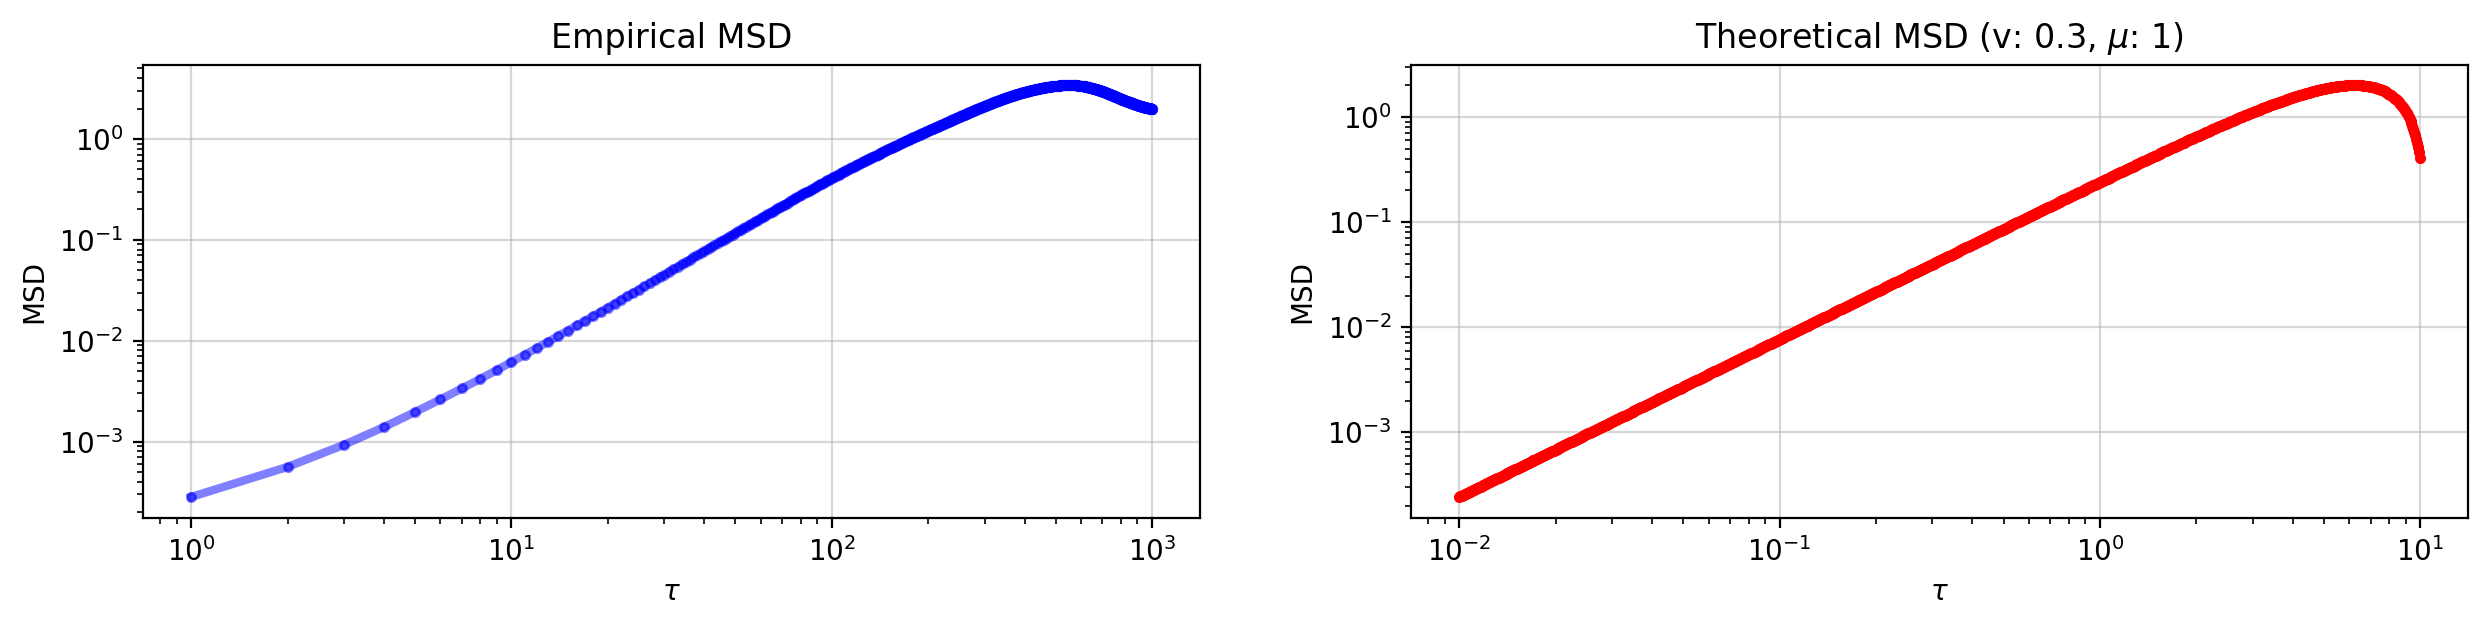

In [216]:
N_i, N = 0, 1000
x_samp, y_samp = tau_vals[N_i:N], emp_MSD[N_i:N]

plt.figure(figsize = (15,3), dpi = 200)
plt.subplot(121)
plt.plot(x_samp, y_samp, 'b.-', alpha=0.5, lw=3, label="empirical MSD")
plot_in_log()
plot_labels()
plt.title('Empirical MSD')

plt.subplot(122)
v = 0.3
mu = 1

# v = 0.26082
# mu = 1.13937

msd_theo = msd_theo_ntl(t,v,mu)
plt.plot(t, msd_theo, 'r.', label = 'v = 1, mu = 1')
plot_in_log()
plot_labels()
plt.title('Theoretical MSD (v: 0.3, $\mu$: 1)')

In [145]:
N_factor = (max(y_samp)-min(y_samp))/(max(msd_theo)-min(msd_theo))
emp_peak = y_samp.tolist().index(max(y_samp))
# theo_peak = msd_theo.tolist().index(max(msd_theo))
# tc = x_samp[emp_peak]/t[theo_peak]
tc = 10**2

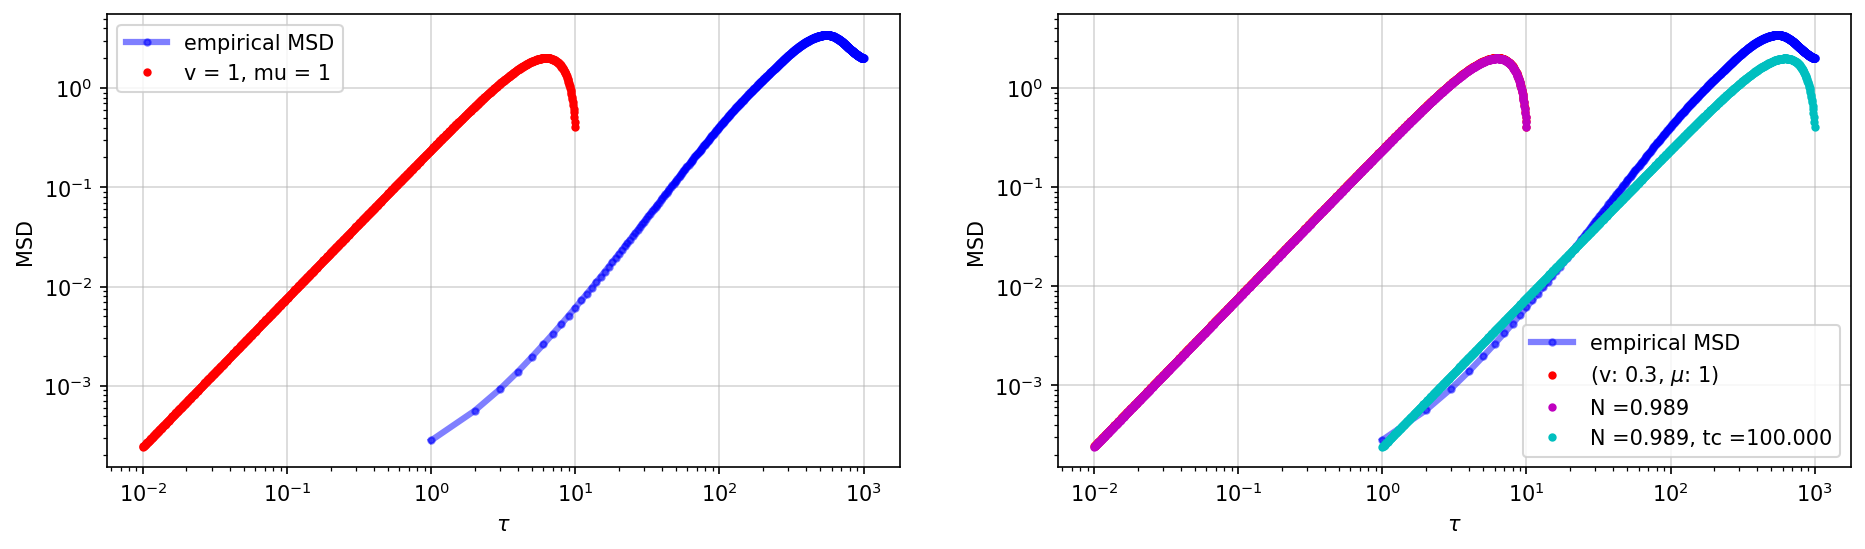

In [219]:
plt.figure(figsize = (15,4), dpi = 150)
plt.subplot(121)
xx = np.logspace(np.log(1e-1), np.log(1.5), 1000)
plt.plot(x_samp, y_samp, 'b.-', alpha=0.5, lw=3, label="empirical MSD")
plt.plot(t, msd_theo_ntl(t, v,mu), 'r.', label = 'v = 1, mu = 1')
plot_in_log()
plot_labels()
plt.legend()

plt.subplot(122)
plt.plot(x_samp, y_samp, 'b.-', alpha=0.5, lw=3, label="empirical MSD")
xx = np.logspace(np.log(1e-1), np.log(1.5), 1000)
plt.plot(t, msd_theo_ntl(t, v, mu), 'r.', label = '(v: 0.3, $\mu$: 1)')
plt.plot(t, N_factor*msd_theo_ntl(t, v, mu), 'm.', label = 'N =%.3f' % (N_factor))
plt.plot(t*tc, N_factor*msd_theo_ntl(t, v, mu), 'c.', label = 'N =%.3f, tc =%.3f' % (N_factor, tc))
plot_in_log()
plot_labels()
plt.legend()

In [229]:
def msd_theo_ss(t,v,mu):
    T = t/tc
    num = gamma(mu)*np.cos((v*T)/2)*jv(1,(v*T)/2)
    denom = np.pi**(-0.5) * T**(0.5-mu) * v**(mu-0.5)
    return num/denom

In [230]:
v = 0.3
mu = 1
initial_ss = [v, mu]

n_tau = 1000

x_fit = tau_vals[:n_tau]
y_fit = emp_MSD[:n_tau]
n_fit = len(i_fit)
popt, pcov = curve_fit(msd_theo_ss, x_fit, y_fit, initial_ss, maxfev=5000)

fit_v, fit_mu = popt[0], popt[1]
err_v, err_mu = pcov[0,0]**0.5, pcov[1,1]**0.5

print("v = %.5f (%.5f), mu = %.5f (%.5f)" % \
      (fit_v, err_v, fit_mu, err_mu))

y_fit = msd_theo_ss(x_samp/tc, fit_v, fit_mu)

v = 0.29777 (0.00085), mu = 1.20209 (0.00289)


In [239]:
msd_theo = msd_theo_ntl(t, fit_v, fit_mu)

In [240]:
N_factor = (max(y_samp)-min(y_samp))/(max(msd_theo)-min(msd_theo))
tc = 10**2

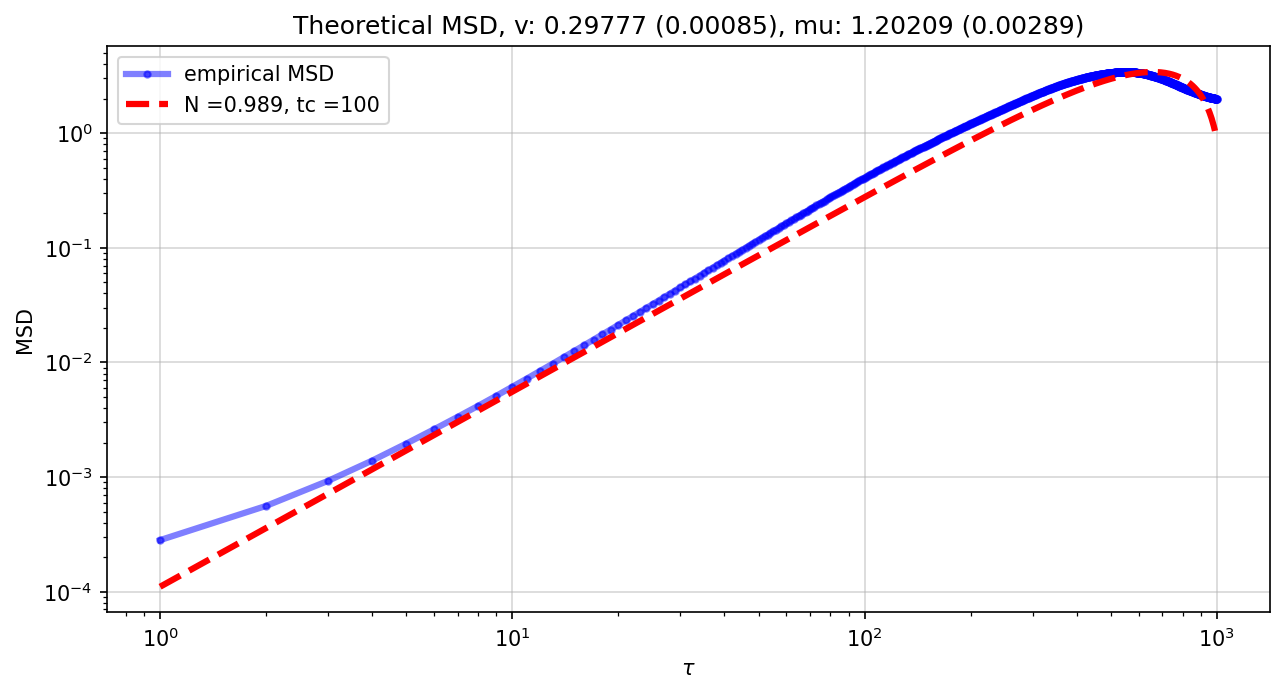

In [241]:
plt.figure(figsize = (10,5), dpi = 150)
plt.plot(x_samp, y_samp, 'b.-', alpha=0.5, lw=3, label="empirical MSD")
plt.plot(t*tc, N_factor*msd_theo, 'r--', lw = 3, label = 'N =%.3f, tc =%1d' % (N_factor, tc))
plot_in_log()
plot_labels()
plt.title("Theoretical MSD, v: %.5f (%.5f), mu: %.5f (%.5f)" % \
      (fit_v, err_v, fit_mu, err_mu))
plt.legend()

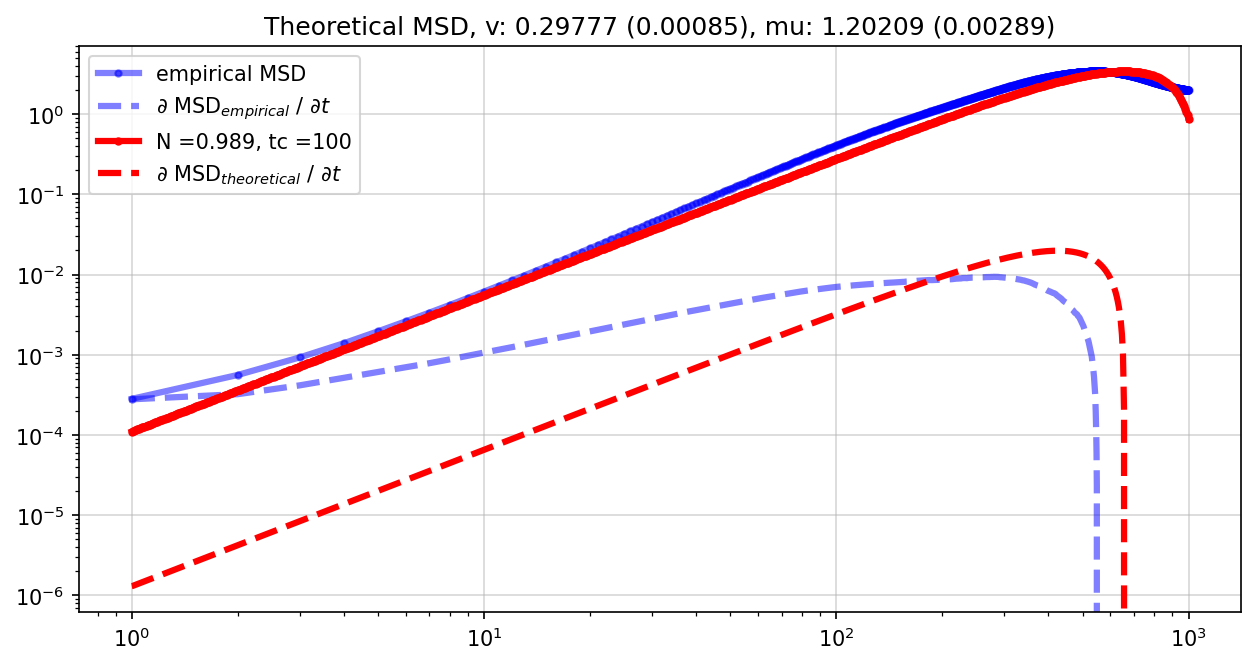

In [300]:
plt.figure(figsize = (10,5), dpi = 150)
plt.plot(x_samp, y_samp, 'b.-', alpha=0.5, lw=3, label="empirical MSD")
plt.plot(x_samp, np.gradient(y_samp), 'b--', alpha=0.5, lw=3, label="$\partial$ MSD$_{empirical}$ / $\partial t$")
plt.plot(t*tc, N_factor*msd_theo, 'r.-', lw = 3, label = 'N =%.3f, tc =%1d' % (N_factor, tc))
plt.plot(t*tc, np.gradient(N_factor*msd_theo), 'r--', lw = 3, label="$\partial$ MSD$_{theoretical}$ / $\partial t$")
plot_in_log()
# plot_labels()
plt.title("Theoretical MSD, v: %.5f (%.5f), mu: %.5f (%.5f)" % \
      (fit_v, err_v, fit_mu, err_mu))
plt.legend()

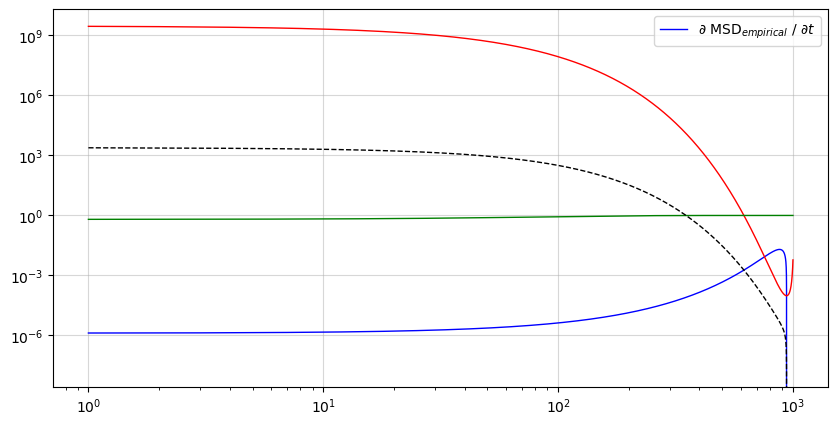

In [320]:
dx = 0.01
m = msd_theo

term_1 = (dx) / (np.sqrt(2 * np.pi)* m**3) 
MSD_prime = np.gradient(m)
term_3 = np.exp(-(dx**2) / (2 * m))
f_t = term_1*MSD_prime*term_3

plt.figure(figsize = (10,5), dpi = 100)
plt.plot(x_samp, MSD_prime, 'b-', lw=1, label="$\partial$ MSD$_{empirical}$ / $\partial t$")
plt.plot(x_samp, term_1, 'r-', lw=1)
plt.plot(x_samp, term_3, 'g-', lw=1)
plt.plot(x_samp, f_t, 'k--', lw=1)
plot_in_log()
plt.legend()

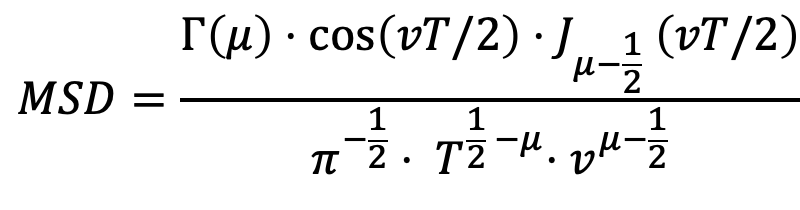

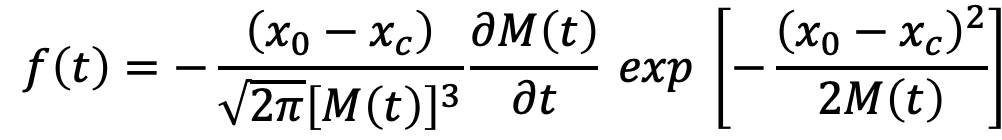

In [340]:
def fptd(dx, mu, v):
    m = msd_theo
    term_1 = np.abs(dx)/(np.sqrt(2 * np.pi)* m**3) 
    MSD_prime = np.gradient(m)
    term_3 = np.exp(-(dx**2)/(2 * m))
    f_t = term_1*MSD_prime*term_3
    return f_t

Text(0, 0.5, 'f(t)')

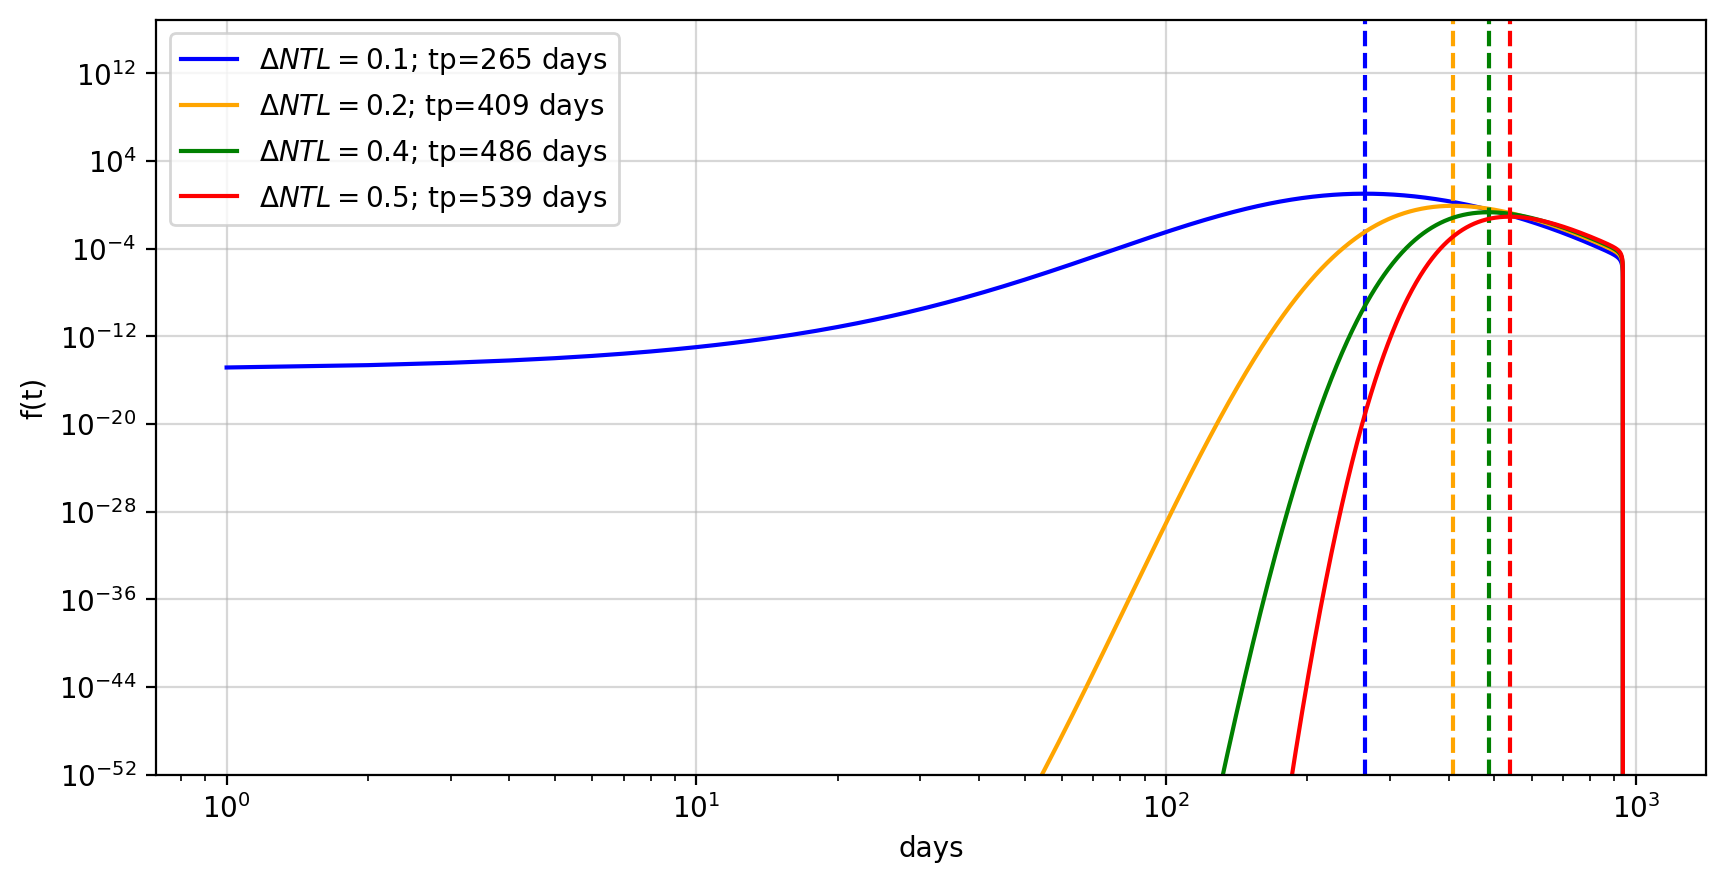

In [360]:
dx_vals = np.linspace(0.1,0.5,4)
colors = ["blue", "orange", "green", "red"]

fig = plt.figure(dpi = 200, figsize = (10,5))
fig.patch.set_facecolor('None')

# plt.subplot(121)
for i,dx in enumerate(dx_vals):
    ft = fptd(dx, mu, v)
    ipeak = np.argmax(ft)
    t_peak = x_samp[ipeak]
    plt.plot(x_samp, ft, color = colors[i], label=r"$\Delta NTL=$"+"%.1f; tp=%.f days" % (dx,t_peak))
    plt.axvline(t_peak, ls='--', color=colors[i])
    plot_in_log()    
plt.legend()
plt.ylim(1e-52,0)
plt.xlabel('days')
plt.ylabel('f(t)')

Text(0, 0.5, 'f(t)')

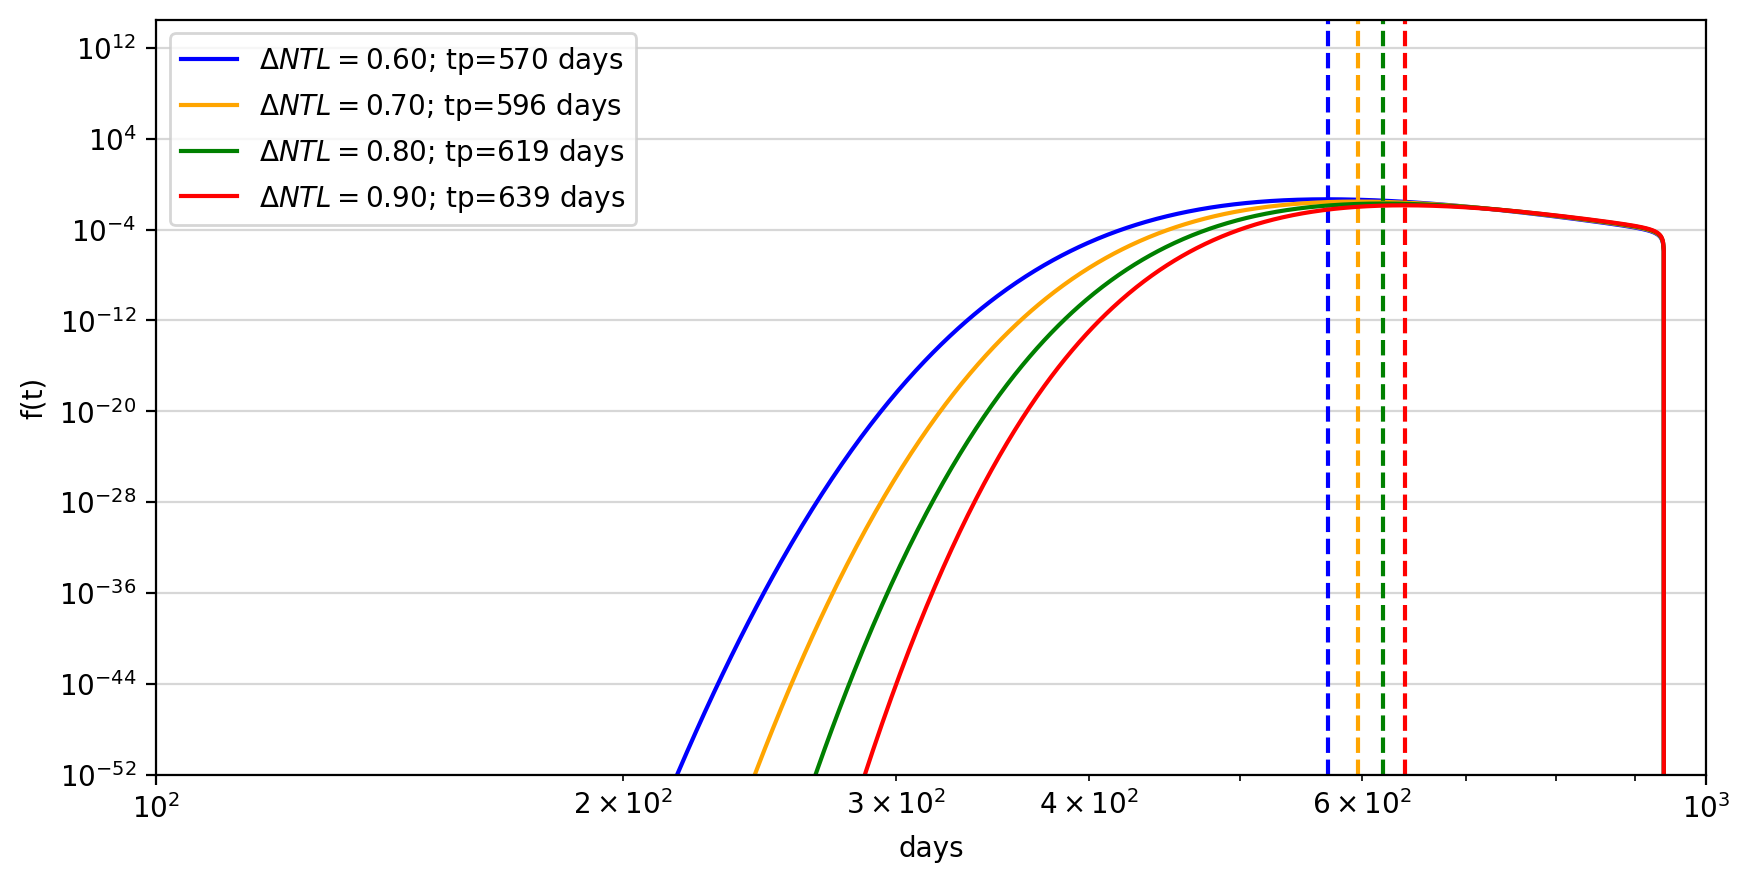

In [361]:
dx_vals = np.linspace(0.6,0.9,4)
colors = ["blue", "orange", "green", "red"]

fig = plt.figure(dpi = 200, figsize = (10,5))
fig.patch.set_facecolor('None')

# plt.subplot(121)
for i,dx in enumerate(dx_vals):
    ft = fptd(dx, mu, v)
    ipeak = np.argmax(ft)
    t_peak = x_samp[ipeak]
    plt.plot(x_samp, ft, color = colors[i], label=r"$\Delta NTL=$"+"%.2f; tp=%.f days" % (dx,t_peak))
    plt.axvline(t_peak, ls='--', color=colors[i])
    plot_in_log()    
plt.legend()
plt.ylim(1e-52,0)
plt.xlim(1e2,1e3)
plt.xlabel('days')
plt.ylabel('f(t)')

In [ ]:
partial_MSD_T(t)

In [262]:
def partial_MSD_T(T,v,mu):
        return (gamma(mu) * np.cos(v * T / 2) * jv(mu - 1/2, v * T / 2)) / (np.sqrt(np.pi) * T**(1/2 - mu) * v**(mu - 1/2)) - \
               (gamma(mu) * np.cos(v * T / 2) * jv(mu - 1/2, v * T / 2) * (1/2) * T**(-3/2 - mu)) / (np.sqrt(np.pi) * v**(mu - 1/2))

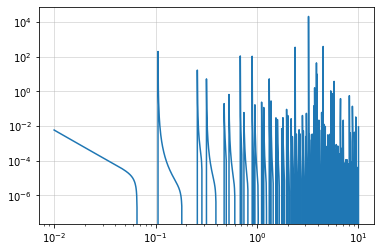

In [304]:
def fptd_ntl(T, dx, mu, v):
    t  = T*tc
    m = msd_theo_ntl(t,v,mu)
    f1 = np.abs(dx) / (np.sqrt(2 * np.pi)* m**3) 
    f2 = np.gradient(m)
    f3 = np.exp(-(dx**2) / (2 * m))
    return f1*f2*f3

plt.plot(t, fptd_ntl(t, 0.1, fit_mu, fit_v))
plot_in_log()

In [ ]:
def fptd_ntl(T, dx, mu, v):
    t  = T*tc
    m = msd_theo_ntl(t,v,mu)
    f1 = np.abs(dx) / (np.sqrt(2 * np.pi)* m**3) 
    f2 = partial_MSD_T(t,v,mu)
    f3 = np.exp(-(dx**2) / (2 * m))
    return f1*f2*f3

In [282]:
v, mu = fit_v, fit_mu

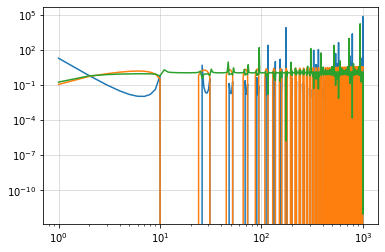

In [283]:
plt.plot(x_samp, 1/(np.sqrt(2 * np.pi) * msd_theo_ntl(x_samp,v,mu)**3))

plt.plot(x_samp, partial_MSD_T(x_samp,v,mu))

plt.plot(x_samp, np.exp(-(1**2) / (2 * msd_theo_ntl(x_samp,v,mu))))

plot_in_log()


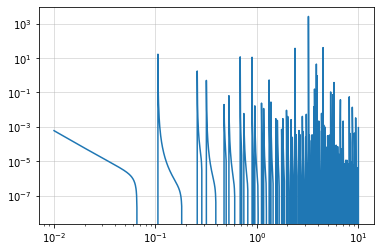

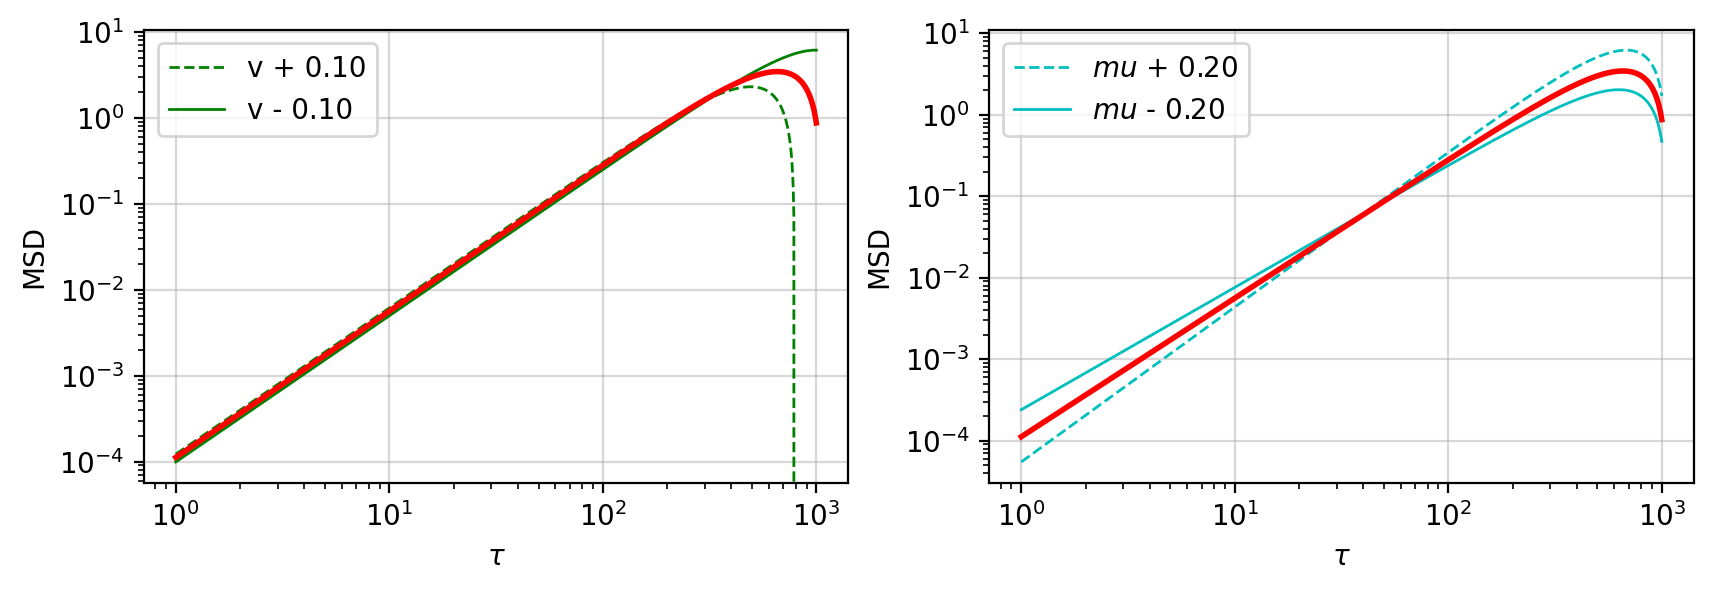

In [211]:
fig = plt.figure(dpi = 200, figsize = (10,3))
fig.patch.set_facecolor('None')

v_shift = 0.1
mu_shift = 0.2

plt.subplot(121)
# plt.plot(x_samp, y_samp, 'b-', alpha=0.5, lw=1, label="empirical MSD")
plt.plot(t*tc, msd_theo_ntl(t, fit_v+v_shift, fit_mu), 'g--', lw = 1, label = "v + %.2f" % (v_shift))
plt.plot(t*tc, msd_theo_ntl(t, fit_v-v_shift, fit_mu), 'g-', lw = 1, label = "v - %.2f" % (v_shift))
plt.plot(t*tc, msd_theo_ntl(t, fit_v, fit_mu), 'r-', lw = 2)
plot_in_log()
plot_labels()
plt.legend()

plt.subplot(122)
# plt.plot(x_samp, y_samp, 'b-', alpha=0.5, lw=1, label="empirical MSD")
plt.plot(t*tc, msd_theo_ntl(t, fit_v, fit_mu+mu_shift), 'c--', lw = 1, label = "$mu$ + %.2f" % (mu_shift))
plt.plot(t*tc, msd_theo_ntl(t, fit_v, fit_mu-mu_shift), 'c-', lw = 1, label = "$mu$ - %.2f" % (mu_shift))
plt.plot(t*tc, msd_theo_ntl(t, fit_v, fit_mu), 'r-', lw = 2)
plot_in_log()
plot_labels()
plt.legend()

In [ ]:
fig = plt.figure(dpi = 200, figsize = (10,4))
fig.patch.set_facecolor('None')

plt.subplot(121)
for i,v in enumerate(v_vals):
    mu = 1
    plt.plot(t*tc, msd_theo_ntl(t, fit_v, fit_mu), '-', color = plt.cm.gnuplot2((i)/12),
             label = r"v: %.2f " % (v))
    plt.title(r"$\mu$: %.2f, varying v" % (mu))
    plot_in_log()
    plot_labels()
    plt.legend(fontsize=7, ncol = 5, bbox_to_anchor= (0, 0.01, 1, 0.5), loc="lower left",
                bbox_transform=plt.gca().transAxes, fancybox = True, mode='expand')
    
# plt.subplot(122)
# for i,mu in enumerate(mu_vals):
#     v = 0.3
#     plt.plot(t, msd_theo_ntl(t,v,mu), '-', color = plt.cm.gnuplot2((i)/12),
#              label = r"$\mu$: %.2f " % (mu))
#     plt.title(r"v: %.2f, varying $\mu$" % (v))
#     plot_in_log()
#     plot_labels()
#     plt.legend(fontsize=7, ncol = 5, bbox_to_anchor= (0, 0.01, 1, 0.5), loc="lower left",
#                 bbox_transform=plt.gca().transAxes, fancybox = True, mode='expand')

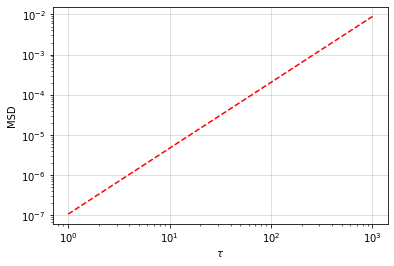

In [139]:
# v = 0.3
# mu = 1

# plt.plot(x_samp, y_samp, 'b.-', alpha=0.5, lw=3, label="empirical MSD")
plt.plot(x_samp, y_fi*, 'r--')
plot_in_log()
plot_labels()

In [137]:
# t = np.logspace(-2, 1, 1000)
# v_vals = np.linspace(1,10,10)
# mu_vals = np.linspace(1,10,10)

# fig = plt.figure(dpi = 200, figsize = (10,4))
# fig.patch.set_facecolor('None')

# plt.subplot(121)
# for i,v in enumerate(v_vals):
#     mu = 1
#     plt.plot(t,msd_theo_ntl(t,v,mu), '-', color = plt.cm.gnuplot2((i)/12),
#              label = r"v: %.2f " % (v))
#     plt.title(r"mu: %.2f, varying $\mu$" % (mu))
#     plot_in_log()
#     plot_labels()
#     plt.legend(fontsize=7, ncol = 5, bbox_to_anchor= (0, 0.01, 1, 0.5), loc="lower left",
#                 bbox_transform=plt.gca().transAxes, fancybox = True, mode='expand')
    
# plt.subplot(122)
# for i,mu in enumerate(mu_vals):
#     v = 0.5
#     plt.plot(t,msd_theo_ntl(t,v,mu), '-', color = plt.cm.gnuplot2((i)/12),
#              label = r"$\mu$: %.2f " % (mu))
#     plt.title(r"v: %.2f, varying v" % (v))
#     plot_in_log()
#     plot_labels()
#     plt.legend(fontsize=7, ncol = 5, bbox_to_anchor= (0, 0.85, 1, 0.5), loc="lower left",
#                 bbox_transform=plt.gca().transAxes, fancybox = True, mode='expand')

In [9]:
 def msd_theo_ss(T,v,mu):
        num = gamma(mu)*np.cos((v*T)/2)*jv(1,(v*T)/2)
        denom = np.pi**(-0.5) * T**(0.5-mu) * v**(mu-0.5)
        return num/denom

    # set range of fitting regime
    tau_fit_min = 1

    x_samp, y_samp = delta_vals_emp[tau_fit_min:tau_fit_max], msd_emp[tau_fit_min:tau_fit_max]

    # set initial values for v, mu, Norm
#     initial_ss = [0.001, 2.46]
    initial_ss = [1, 1]
#     initial_ss = [0.1, 2.46]

    n_tau = len(delta_vals_emp)
    i_fit = np.arange(n_tau)[(delta_vals_emp >= tau_fit_min) & (delta_vals_emp < tau_fit_max)]
    # i_fit
    x_fit = delta_vals_emp[i_fit]
    y_fit = msd_emp[i_fit]
    n_fit = len(i_fit)
    popt, pcov = curve_fit(msd_theo_ss, x_fit, y_fit, initial_ss, maxfev=5000)

    fit_v, fit_mu = popt[0], popt[1]
    err_v, err_mu = pcov[0,0]**0.5, pcov[1,1]**0.5


    print("v = %.5f (%.5f), mu = %.5f (%.5f)" % \
          (fit_v, err_v, fit_mu, err_mu))

    xx = np.logspace(np.log(1e-2), np.log(1e2), tau_fit_max-1)

#     y_fit = msd_theo_ss(x_samp, fit_v, fit_mu)
    y_fit = msd_theo_ss(xx, fit_v, fit_mu)
    

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 7)

In [115]:
emp_MSD = MSD_trend_df.dropna(how='all')
emp_MSD = empirical_MSD[empirical_MSD['NCR'] != 0]
emp_MSD

,Region XII,Region VI,Region II,ARMM,Region IV-A,Region I,Region XI,Region IX,Region III,NCR,Region XIII,Region VII,Region VIII,Region X,CAR
1,1.373686e-07,2.505249e-07,2.093314e-07,1.040961e-07,0.000001,4.324803e-07,1.769625e-07,1.184099e-07,6.713778e-07,0.000282,1.412047e-07,3.264075e-07,2.029684e-07,1.356483e-07,1.833834e-07
2,2.627491e-07,4.790581e-07,4.009673e-07,2.027842e-07,0.000002,8.112249e-07,3.514803e-07,2.272876e-07,1.301591e-06,0.000561,2.653071e-07,6.348276e-07,3.796273e-07,2.605023e-07,3.456291e-07
3,4.196534e-07,7.651666e-07,6.370537e-07,3.279231e-07,0.000004,1.275303e-06,5.782119e-07,3.664550e-07,2.102756e-06,0.000928,4.221885e-07,1.028450e-06,5.974963e-07,4.200763e-07,5.474923e-07
4,6.126077e-07,1.122890e-06,9.189755e-07,4.820801e-07,0.000005,1.846937e-06,8.608872e-07,5.372340e-07,3.129208e-06,0.001392,6.134459e-07,1.524209e-06,8.631643e-07,6.198094e-07,7.914536e-07
5,8.435738e-07,1.553360e-06,1.247377e-06,6.655336e-07,0.000008,2.537192e-06,1.200152e-06,7.401565e-07,4.399730e-06,0.001960,8.396346e-07,2.122872e-06,1.175613e-06,8.617042e-07,1.079199e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3267,1.079690e-04,2.488644e-04,1.539422e-05,6.571028e-06,0.005624,4.423399e-04,1.920896e-04,9.106118e-06,3.011999e-03,0.635107,3.932382e-06,4.476448e-04,3.931128e-09,1.747790e-05,8.330003e-07
3268,8.736536e-05,2.010283e-04,1.259257e-05,5.436980e-06,0.004525,3.551725e-04,1.554606e-04,7.492257e-06,2.422774e-03,0.510415,3.307107e-06,3.620286e-04,6.253714e-09,1.434117e-05,6.439801e-07
3269,6.617442e-05,1.521126e-04,9.708738e-06,4.208502e-06,0.003413,2.677978e-04,1.178527e-04,5.763403e-06,1.827007e-03,0.384281,2.606749e-06,2.744170e-04,9.431302e-09,1.102199e-05,4.564845e-07
3270,4.468065e-05,1.024471e-04,6.645020e-06,2.913456e-06,0.002287,1.795655e-04,7.953019e-05,3.972114e-06,1.223898e-03,0.257467,1.819374e-06,1.853105e-04,1.307318e-08,7.549984e-06,2.838738e-07


In [6]:
def msd_theo_ss(T,v,mu):
    num = gamma(mu)*np.cos((v*T)/2)*jv(1,(v*T)/2)
    denom = np.pi**(-0.5) * T**(0.5-mu) * v**(mu-0.5)
    return num/denom